In [1]:
# local office server version
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
'''Disordered PUs, for 'train and test different setting'
one channel per logit version, multiple SNR or multiple volumn"
2023 Feb version, use PSD from matlab'''
import csv
#import numpy as np
from numpy.random import RandomState
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
#import random

import torch
#torch.cuda.set_device(0)
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
import math
import torchvision
import torchvision.transforms as transforms
import torch.utils.data.distributed as TUDdistributed
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
import sys
from copy import deepcopy
import random
import collections
from scipy import signal
import datetime
import shutil
from pytz import timezone
import time
TMZ = timezone('EST')

device = torch.device("cuda")
#use_cuda = True
criterion = nn.CrossEntropyLoss()


def avg_signal_pw(assign_dict, beta, alpha, nPU, nSU, nch, DistAmp):
  #calculate average signal power per freq_pt
  #
  total_pw = 0
  for SU in range(nSU):
    for PU in range(nPU):
      total_pw=total_pw+len(assign_dict['PU'+str(PU)])*(beta*((DistAmp*dist_dict[PU][SU])**alpha))**(-1)

  avg_pw = total_pw/(nSU*nch)
  print(avg_pw)
  return avg_pw

In [3]:
ll = [3,-4]
lb = ll*(-1)
print(lb)

[]


{0: [2, -1.7320508075688772], 1: [0, -1.7320508075688772], 2: [-2, -1.7320508075688772], 3: [3, 0], 4: [1, 0], 5: [-1, 0], 6: [-3, 0], 7: [2, 1.7320508075688772], 8: [0, 1.7320508075688772], 9: [-2, 1.7320508075688772]}
PU 0 :  [4.618802153517006, 4.163331998932265, 3.055050463303893, 3.055050463303893, 2.309401076758503, 4.163331998932265, 3.0550504633038935, 2.309401076758503, 1.1547005383792515, 1.1547005383792515]
PU 1 :  [3.055050463303893, 3.055050463303893, 2.309401076758503, 3.055050463303893, 3.055050463303893, 2.309401076758503, 1.1547005383792515, 1.1547005383792515, 1.1547005383792515, 2.309401076758503]
PU 2 :  [2.309401076758503, 3.055050463303893, 3.055050463303893, 4.163331998932265, 4.618802153517006, 1.1547005383792515, 1.1547005383792515, 2.309401076758503, 3.0550504633038935, 4.163331998932265]
PU 3 :  [5.033222956847166, 4.163331998932265, 3.0550504633038935, 2.309401076758503, 1.1547005383792515, 5.033222956847166, 4.163331998932265, 3.0550504633038935, 2.30940107

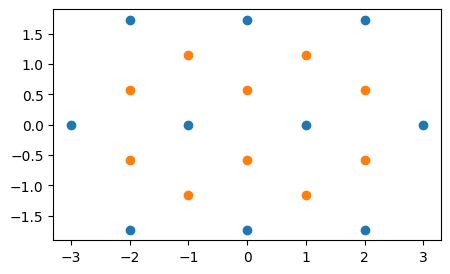

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# only need to amplify distance dict/list. no need to 
locat_endpt = { # location of 10 pts, regular triangle side-length=2 mode
   0: [-2, 3**.5], 
   1: [0, 3**.5],
   2: [2, 3**.5],
   3: [-3, 0],
   4: [-1, 0],
   5: [1, 0],
   6: [3, 0],
   7: [-2, -3**.5],
   8: [0, -3**.5],
   9: [2, -3**.5],
}

for i in range(10): # central symmetry operation 
  locat_endpt[i] = [-1*locat_endpt[i][0], -1*locat_endpt[i][1]] 

print(locat_endpt)



locat_centre = { # location of 10pts, centre of regular traingles with sinde-length=2
    0: [-2, 3**.5/3],
    1: [-1, 2/3*3**.5],
    2: [0, 3**.5/3],
    3: [1, 2/3*3**.5],
    4: [2, 3**.5/3],
    5: [-2, -3**.5/3],
    6: [-1, -2/3*3**.5],
    7: [0, -3**.5/3],
    8: [1, -2/3*3**.5],
    9: [2, -3**.5/3],
}
x = [locat_endpt[i][0] for i in range(10)]
x1 = [locat_centre[i][0] for i in range(10)]
y = [locat_endpt[i][1] for i in range(10)]
y1 = [locat_centre[i][1] for i in range(10)]
# print(x)
# print(y)
plt.figure(figsize=(5, 3))
plt.scatter(x,y)
plt.scatter(x1,y1)
plt.show
# plt.plot()
# dist_dict = {i:[dist_ori[(j-i)%10]+(random.random()*0.8-0.4)*disAmp for j in range(nnode)] for i in range(nch)}
'''First assume that PUs at locat_endpt, SUs at locat_centre'''
dist_dict = {i: [np.linalg.norm( np.array(locat_endpt[i])-np.array(locat_centre[j]) ) for j in range(len(locat_centre))] for i in range(len(locat_endpt))} #nch(or PU, exactly): distance to each SU. 
dist_dict1 = {i: [np.linalg.norm( np.array(locat_centre[i])-np.array(locat_endpt[j]) ) for j in range(len(locat_endpt))] for i in range(len(locat_centre))} #SU at endpt, PU at center case
for i in range(len(dist_dict)):
  print('PU',i,': ', dist_dict[i])
# print(dist_dict)

In [5]:
# import math
# import numpy as np
# -3**.5
# 2/3*3**.5
# len(locat_endpt)
# out = np.array([1,2]) - np.array([1.2, 2.3])

# print(np.linalg.norm(out))

In [6]:
# assign_dict10 = {  #seems useless
#     'description': 'The bands allocated to each PU. for 10-band-case',
#     'nPU': 10,
#     'PU0':[0],
#     'PU1':[1],
#     'PU2':[2],
#     'PU3':[3],
#     'PU4':[4],
#     'PU5':[5],
#     'PU6':[6],
#     'PU7':[7],
#     'PU8':[8],
#     'PU9':[9],
# }

class_dir10 = [ #observable PUs for an SU
    [0,3,4], 
    [0,1,4],
    [1,4,5],
    [1,2,5],
    [2,5,6],
    [3,4,7],
    [4,7,8],
    [4,5,8],
    [5,8,9],
    [5,6,9]
]

class_dir10 = [ #new ver Feb 2024 aft central symmetric PU. 
     [5,6,9]
    , [5,8,9]
    , [4,5,8]
    , [4,7,8]
    , [3,4,7]
    ,[2,5,6]
    ,[1,2,5]
    ,[1,4,5]
    ,[0,1,4]
    ,[0,3,4]
]


assign_dict20 = { 
    'description': 'The bands allocated to each PU. for 20-band-case, 3 single-band PUs, 4 double-band PUs, 3 triple-band PUs',
    'nPU': 10,
    'PU0':[0],
    'PU1':[1, 10],
    'PU2':[2, 11, 14],
    'PU3':[3],
    'PU4':[4, 19],
    'PU5':[5, 13],
    'PU6':[6, 15, 17],
    'PU7':[7, 12, 18],
    'PU8':[8, 16],
    'PU9':[9],
}

# class_dir_20 = [ class_dir10[SU] for SU in range(len(class_dir10))]
# for PU in class_dir10[SU]
class_dir20 = [[ ] for i in range(len(class_dir10))] #make empty classdir20
for SU in range(len(class_dir10)):
    for PU in class_dir10[SU]:
        class_dir20[SU].extend(assign_dict20['PU'+str(PU)]) 

for SU in range(len(class_dir20)):
  print('SU',SU,' observable bands: ', class_dir20[SU])

print(class_dir20)

SU 0  observable bands:  [5, 13, 6, 15, 17, 9]
SU 1  observable bands:  [5, 13, 8, 16, 9]
SU 2  observable bands:  [4, 19, 5, 13, 8, 16]
SU 3  observable bands:  [4, 19, 7, 12, 18, 8, 16]
SU 4  observable bands:  [3, 4, 19, 7, 12, 18]
SU 5  observable bands:  [2, 11, 14, 5, 13, 6, 15, 17]
SU 6  observable bands:  [1, 10, 2, 11, 14, 5, 13]
SU 7  observable bands:  [1, 10, 4, 19, 5, 13]
SU 8  observable bands:  [0, 1, 10, 4, 19]
SU 9  observable bands:  [0, 3, 4, 19]
[[5, 13, 6, 15, 17, 9], [5, 13, 8, 16, 9], [4, 19, 5, 13, 8, 16], [4, 19, 7, 12, 18, 8, 16], [3, 4, 19, 7, 12, 18], [2, 11, 14, 5, 13, 6, 15, 17], [1, 10, 2, 11, 14, 5, 13], [1, 10, 4, 19, 5, 13], [0, 1, 10, 4, 19], [0, 3, 4, 19]]


In [7]:
# print( 10**(-0.365*torch.randn(1).item()) )

In [8]:
''' 
jan 2024, Set dist to generate diff distance btw PU SU
Feb20, 2023 ver, apply 64 dim PSD from MATLAB
'''
nw = 64 # bandwidth 64 freq pts （2023）
nSU = len(class_dir20)

address = '' # 2023 Feb MATLAB data
name = 'clean_PSD_6mod_Mat.pth'
cleanPSD = torch.load(address+name) # load saved clean PSDs
#Check saved PSDs
print(cleanPSD['Description'])

def data_generator_dist(DistAmp, class_dir, dbsize_list, nch, nw, assign_dict, SNR, dist_dict, PSD_lib=cleanPSD, alpha = 3.71, beta = 10**3.154): 
    '''
    2023 version modified:

    Database for collective learning, 
    emited signals from MATLAB, 64 pts per band, 
    then apply noises and path-losses to received signals on nodes
    '''
    label_list =[] # label list of training data
    db = [] # dataset (list)
    nPU = assign_dict['nPU'] #num of PUs
    # Calculating noise_pw based on dist_dict
    # DistAmp = 10 #if 1, regular triangular side-length=2 # Distance Amplifier

    nSU = len(class_dir)
    avg_pw = avg_signal_pw(assign_dict, beta, alpha, nPU, nSU, nch, DistAmp) #avg_power/freq_pt
    noi_pw = avg_pw*10**(-1*SNR/10)

    for cls in range(2**nPU): #for every occupation condition       # idx of occupation class 
        for n in range( dbsize_list[cls] ):#repeat for all samples in this class     
            inp = []   # a list of input tensors of all nodes           
            label = torch.zeros(nch)
            PSDidx = [random.randrange(10) for k in range(nPU)] # fixed PSD for certain PU 
            for SU in range(len(class_dir)): # a set of node-received data
                a = torch.randn(1,nw,nch) * noi_pw # new 2023Feb local noise
                
                for PU in range(nPU): # for each channel
                    if cls & (2**(PU)) : #find active PU for this cls  
                             #print('occupied channel',ch)
                        ch_gain=(beta * ((DistAmp*dist_dict[PU][SU])**alpha))**(-1)# To be updated
                        ch_gain=ch_gain*10**(-0.365*torch.randn(1).item()) #shadow fading
                        for ch in assign_dict['PU'+str(PU)]:
                            label[ch] = 1
                            #apply clean signal
                            rcv_sig = PSD_lib[PU%6+1][PSDidx[PU]]
                            pw = sum(rcv_sig[64:128])/64
                            rcv_sig = rcv_sig/pw * ch_gain #unit power per freq pts and apply channel gain
                            '''False to normalize after pathloss
                            Pathloss model to be reviewed
                            Average SNR to be plug-in'''
                            a[0,:,ch].add_(torch.tensor(rcv_sig[64:128])[:,0]) # Apply Path-loss # Use [:,0] to convert [192,1] to [192]
                            if ch > 0: #cls not left most
                                a[0, :, ch-1].add_(torch.tensor(rcv_sig[0:64] )[:,0]) #apply leakage to left neighbor channel
                            if ch < (nch-1):  #cls not right most
                                a[0, :, ch+1].add_(torch.tensor(rcv_sig[-64:192] )[:,0]) #apply leakage to right neighbor channel

                inp.append(torch.abs(a))        

            db.append(deepcopy(inp))  # add to dataset list      
            label_list.append(deepcopy(label))  # add label to list
    return db, label_list #, noi

def setDir(filepath):
  # if directory not exist, create. if directory already exist, empty it.
  if not os.path.exists(filepath):
    os.makedirs(filepath)
  else:
    shutil.rmtree(filepath, ignore_errors = True)
    os.makedirs(filepath)

from Matlab, PSD of 6 narrowband sig (4 PSKs, FSK, QAM), length =64, type is 1D numpy ndarray tensor. each key has a list of 10 set 192-dim PSDs


In [9]:
'''New PU placement (central symmetric vs before)
2024Spr Ver: 20/ocp Tr; 5/ocp Te, can set PU SU distences and alpha values
Generate and save dataset under multiple SNR'''
time_start=time.time()
nch=20
nPU = assign_dict20['nPU']
ncls = 2**nPU
DistAmp = 10 # 25
alpha = 3.71 #3.71
volumn = (1, 5) #volumn/ocp for (training and testing)  (20, 1)  (10, 1)
dbsize_list = [volumn[0] for i in range(ncls)] # size of train data in each class
'''Just want testing'''
# for SNR in range(11):
address1 = 'RefinedNewData/SNRs/'+str(DistAmp)+'m_Alpha'+str(alpha)+'/'
address1 = 'RefinedNewData/SNRs/PUswitch/'

now =datetime.datetime.now()
time_watermark = now.strftime('%y%m%d_%H_%M')
save_dir=address1+time_watermark+'/'
setDir(save_dir)

for snr in [ 8]: #[ 2, 4, 6, 10, 12, 14, 16] [0, 2, 4, 6, 8, 10, 12, 14, 16][8]: #[4, 8, 12, 16]:[ 4, 8, 12, 16, 20, 0]
    SNR=-1*snr
    datas_tr, labels_tr = data_generator_dist(DistAmp, class_dir20, dbsize_list, nch, nw, assign_dict20, SNR, dist_dict, PSD_lib=cleanPSD, alpha = 3.71, beta = 10**3.154)
    time_end=time.time()
    '''testing set'''
    dbsize_list_te = [volumn[1] for i in range(ncls)] # size of test data in each class

    datas_te, labels_te= data_generator_dist(DistAmp, class_dir20, dbsize_list_te, nch, nw, assign_dict20, SNR, dist_dict, PSD_lib=cleanPSD, alpha=alpha, beta = 10**3.154)

    '''data saving'''

    db = {
        'Description': 'cleanPSD64.pth, SNR'+str(SNR)+'dB, '+str(nch)+'bands/PUs, '+'64 pts/band.',
        'training data list': datas_tr,
        'training label list': labels_tr,
        'testing data list': datas_te,
        'testing label list': labels_te,
        'time':'TBD',
        'classdir': class_dir20,
    }

    name1 = 'Data_SNR'+str(SNR)+'vol'+str(volumn[0])+'.pth' #W/O time watermark child dir
    db['time'] = time_watermark # apply watermark to db dict
    torch.save(db, save_dir + name1)
    print('dataset saved to: '+save_dir + name1)

    time_end=time.time()
    print('time cost',time_end-time_start,'s')    

2.6134768430854427e-08


2.6134768430854427e-08
dataset saved to: RefinedNewData/SNRs/PUswitch/240209_22_36/Data_SNR-8vol1.pth
time cost 34.08287835121155 s


In [10]:
'''Generate and save dataset under multiple SNR'''
time_start=time.time()
nch=20
nPU = assign_dict20['nPU']
ncls = 2**nPU
volumn = (40, 1) #volumn/ocp for (training and testing)  (20, 1)  (10, 1)
dbsize_list = [volumn[0] for i in range(ncls)] # size of train data in each class
'''Generan Training data, will be saved later'''
# for SNR in range(11):
address1 = 'RefinedNewData/SNRs/'
now =datetime.datetime.now()
time_watermark = now.strftime('%y%m%d_%H_%M')
save_dir=address1+time_watermark+'/'
setDir(save_dir)

for snr in [10]: #[8]: #[4, 8, 12, 16]:[ 4, 8, 12, 16, 20, 0]
    SNR=-1*snr
    datas_tr, labels_tr = data_generator(class_dir20, dbsize_list, nch, nw, assign_dict20, SNR, dist_dict, PSD_lib=cleanPSD, alpha = 3.71, beta = 10**3.154)
    time_end=time.time()
    '''testing set'''
    dbsize_list_te = [volumn[1] for i in range(ncls)] # size of test data in each class
    datas_te, labels_te= data_generator(class_dir20, dbsize_list_te, nch, nw, assign_dict20, SNR, dist_dict, PSD_lib=cleanPSD, alpha = 3.71, beta = 10**3.154)

    '''data saving'''

    db = {
        'Description': 'cleanPSD64.pth, SNR'+str(SNR)+'dB, '+str(nch)+'bands/PUs, '+'64 pts/band.',
        'training data list': datas_tr,
        'training label list': labels_tr,
        'testing data list': datas_te,
        'testing label list': labels_te,
        'time':'TBD',
        'classdir': class_dir20,
    }

    name1 = 'Data_SNR'+str(SNR)+'vol'+str(volumn[0])+'.pth' #W/O time watermark child dir
    db['time'] = time_watermark # apply watermark to db dict
    torch.save(db, save_dir + name1)
    print('dataset saved to: '+address1+name1)

    time_end=time.time()
    print('time cost',time_end-time_start,'s')    

NameError: name 'data_generator' is not defined

In [ ]:
#To shutdown workspace
from google.colab import runtime
runtime.unassign()

In [ ]:
'''Generate and save dataset under multiple volumn'''
time_start=time.time()
nch=20
nPU = assign_dict20['nPU']
ncls = 2**nPU
volumn = (10, 1) #volumn/ocp for (training and testing)
dbsize_list = [volumn[0] for i in range(ncls)] # size of train data in each class
'''Generan Training data, will be saved later'''
# for SNR in range(11):
SNR= -6
address1 = 'RefinedNewData/Vols/'
setDir(address1)

for Vol in [1,2,5, 10, 50]:
    volumn = (Vol, 1)
    datas_tr, labels_tr = data_generator(class_dir20, dbsize_list, nch, nw, assign_dict20, SNR, dist_dict, PSD_lib=cleanPSD, alpha = 3.71, beta = 10**3.154)
    time_end=time.time()
    '''testing set'''
    dbsize_list_te = [volumn[1] for i in range(ncls)] # size of test data in each class
    datas_te, labels_te= data_generator(class_dir20, dbsize_list_te, nch, nw, assign_dict20, SNR, dist_dict, PSD_lib=cleanPSD, alpha = 3.71, beta = 10**3.154)

    '''data saving'''
    now =datetime.datetime.now()
    time_watermark = now.strftime('%y%m%d_%H_%M')
    db = {
        'Description': 'cleanPSD64.pth, SNR'+str(SNR)+'dB, '+str(nch)+'bands/PUs, '+'64 pts/band.',
        'training data list': datas_tr,
        'training label list': labels_tr,
        'testing data list': datas_te,
        'testing label list': labels_te,
        'time':'TBD',
        'classdir': class_dir20,
    }

    name1 = time_watermark+'Data_SNR'+str(SNR)+'vol'+str(volumn[0])+'.pth' #W/O time watermark child dir
    db['time'] = time_watermark # apply watermark to db dict
    torch.save(db, address1 + name1)
    print('dataset saved to: '+address1+name1)

    time_end=time.time()
    print('time cost',time_end-time_start,'s')

In [ ]:
print(class_dir20)

In [ ]:
load_db = torch.load('CSS_103_3_test.pth')
db, db_te, label_list, label_list_te = load_db['train_data'], load_db['test_data'], load_db['train_label'], load_db['test_label']

In [ ]:
'''To verify reshape is good to flatten decoupled layer feature map'''
bn = 2
fn = 3
FeatureMap = (2,2)
tp = (bn,fn) + FeatureMap
# fm = torch.rand(bn,fn,FeatureMap) #(batchnum, filternum, FeatureMap2Dim)
fm = torch.rand(tp)
print('feature map shappe:',fm.shape)
print('Original_Feature_Map:\n',fm)
# print(tp)
# fm.squeeze()
# print('batch num:',fm.size(0))
# torch.reshape(fm, (fm.size(0),-1))
fm.view((fm.size(0),-1))

In [ ]:
# cfg = [10, 10, 10, 10]
# layers = [
#         nn.Conv2d(1, cfg[0], kernel_size=3, padding = 1 ),
#             nn.BatchNorm2d(cfg[0]),
#             nn.ReLU(inplace=True),
#         nn.Conv2d(cfg[0], cfg[1], kernel_size=3, padding = 1),
#             nn.BatchNorm2d(cfg[1]),
#             nn.ReLU(inplace=True),
#         nn.MaxPool2d(kernel_size=(4,1) ),
#         nn.Conv2d(cfg[1], cfg[2], kernel_size=3, padding = 1),
#             nn.BatchNorm2d(cfg[2]),
#             nn.ReLU(inplace=True),
#         nn.MaxPool2d(kernel_size=(2,1) ),
#         nn.Conv2d(cfg[2], cfg[3], kernel_size=3, padding = 1),
#             nn.BatchNorm2d(cfg[3]),
#             nn.ReLU(inplace=True),
#         nn.AvgPool2d(kernel_size=(4,5) ),
# ]
# # print(layers)
# print(layers[-5])
# layers[-5] = nn.MaxPool2d(kernel_size=(2,2) )
# print(layers[-5])
# print(layers)

In [ ]:
'''July -- Oct'''
class_dir = [[0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9],[9,0]]
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #plt.imshow(np.transpose(npimg, cmap = 'gray', interpolation='nearest' ))
    plt.rcParams['figure.figsize'] = (12., 8.)
    plt.imshow(-1*img , cmap = 'gray', vmin = -0.0001, vmax = 0.00000, interpolation='nearest'   )# notice its negative
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()


ns = 3 # ocp mode
j = 0 # node
sz = tesize# size per occupation
for i in range(len(class_dir)): # loop for nodes
    imshow(abs(db_te[sz*ns][i][0]))
#     print(db[j*ns +1][i][0])
#     print(torch.max(db_te[sz*ns ][i][0]) )
    print('max value',torch.max(db_te[sz*ns ][i][0]) )
    print('min value',torch.min(db_te[sz*ns ][i][0]) )
    print('max band energy', torch.max( torch.sum(db_te[sz*ns ][i][0]**2, -2)) )
#     print(db[i*ns +1][0])
#     print(np.max(db[i*10 +4]))
#     print(label_list_te[sz*ns])
    print(label_list_te[sz*ns])

In [ ]:
db_tr_list = []
# for idx in range(len(class_dir)):# train datasets are more complex
#     db_tr_list.append(NodeDatasetMaker( db, label_list, idx, class_dir, transforms.Compose([ ]) ))
db_te_1 = TotalDatasetMaker( db_te, label_list_te, transforms.Compose([ ]) )

# train_loader_list = []
# for idx in range(len(class_dir)):# trainloaders are more complex
#     train_loader_list.append(DataLoader(db_tr_list[idx], batch_size=100, shuffle=True, num_workers=0, pin_memory=True))
# # tol_train_loader = DataLoader(tol_trainsets, batch_size=100, shuffle=False, num_workers=0, pin_memory=True)

tol_test_loader = DataLoader(db_te_1, batch_size=100, shuffle=False, num_workers=0, pin_memory=True)

In [ ]:
len(db)

In [ ]:
# '''103 version, for energy detection'''
def energy_detection_coop(thresh_list, class_dir, test_loader):                             
#     '''Tests all nodes together, use TotalDatasetMaker, smarter distrib energy detection'''
#     '''thresh_list is the thresh for diff nodes, by default they're the same'''
    total = 0 #sum of occupation and emptiness
    test_loss = 0 
    total_ocp = 0 #occupied bands
    total_emp = 0 #empty bands
    correct = 0
    total_cmb = 0  #occupation combination
    correct_ocp = 0
    correct_emp = 0
    correct_cmb = 0

    for batchidx, (data, target) in enumerate(test_loader):
        #data, target = data.cuda(), target.cuda()
        #print(target.size())
#             data, target = Variable(data), Variable(target)
        target = Variable(target)
#             print('target size is:',target.size())
        output_manual = torch.zeros(target.shape).bool() # manual global decision of CNN
        total_batch = float(torch.tensor(target.size()).prod()) #total num of channels in this batch
        total += total_batch
        total_cmb += float(target.size(0))
        total_ocp += float(target.sum())
        total_emp += float(total_batch - target.sum()) 
        if (1-target).sum() != (torch.tensor(target.size()).prod() - target.sum()) : #Testing tensor dim =========
            print('show difference:',(1-target).sum(), total - target.sum())
            print('total ocp/emp calculation wrong')
        '''Above calculate the total number of channels detected and the ground truth number of occupation/emptiness'''

        for idx in range(len(class_dir)): # apply fusion strategy on local detections
            node_power = torch.sum(data[idx]**2, dim = -2)#  # get (batchsize*2) tensors of local channel power
            output_manual[:,class_dir[idx]] = output_manual[:,class_dir[idx]]| (node_power[:,0,class_dir[idx]]>thresh_list[idx])
            # strategy: any node detects means occupation
        correct_ocp += (output_manual*target).sum()
        correct_emp += ((~output_manual)*(1-target)).sum()
        correct_cmb += (~(output_manual^target.bool())).float().prod(1).sum() #use XNOR which is 'not+XOR'
#         print('correctocp',correct_ocp)

    correct_tol = deepcopy(correct_ocp) + deepcopy(correct_emp) #just sum
    accuracy_tol = 100*correct_tol/total
    accuracy_pd = 100*correct_ocp/total_ocp
    accuracy_pfa = 100*correct_emp/total_emp
    accuracy_cmb = 100*correct_cmb/total_cmb

#     print('++++++++++++++++++ Accuracy on global set: total: %d %%, combination: %d %%, PD: %d %%, PFA: %d %%' \
#                                             % ( accuracy_tol, accuracy_cmb, accuracy_pd, 100-accuracy_pfa))
    Acc_set = (accuracy_tol, accuracy_cmb, accuracy_pd, 100-accuracy_pfa)
    return Acc_set

'''Tests all nodes together, use TotalDatasetMaker, dumb distrib energy detection'''
def energy_detection_blind(thresh_list, class_dir, test_loader):                             
    
    total = 0 #sum of occupation and emptiness
    test_loss = 0 
    total_ocp = 0 #occupied bands
    total_emp = 0 #empty bands
    correct = 0
    total_cmb = 0  #occupation combination
    correct_ocp = 0
    correct_emp = 0
    correct_cmb = 0

    for batchidx, (data, target) in enumerate(test_loader):
        #data, target = data.cuda(), target.cuda()
        #print(target.size())
#             data, target = Variable(data), Variable(target)
        target = Variable(target)
#             print('target size is:',target.size())
        output_manual = torch.zeros(target.shape) # manual global decision
        total_batch = float(torch.tensor(target.size()).prod()) #total num of channels in this batch
        total += total_batch
        total_cmb += float(target.size(0))
        total_ocp += float(target.sum())
        total_emp += float(total_batch - target.sum()) 
        if (1-target).sum() != (torch.tensor(target.size()).prod() - target.sum()) : #Testing tensor dim =========
            print('show difference:',(1-target).sum(), total - target.sum())
            print('total ocp/emp calculation wrong')
        '''Above calculate the total number of channels detected and the ground truth number of occupation/emptiness'''

        for idx in range(len(class_dir)): # apply fusion strategy on local detections
            local_output = torch.sum(data[idx]**2, dim = -2)[:,0,:] >thresh_list[idx]#local decisions
            output_manual += local_output.float()/len(class_dir) #bool + bool can be int
            # strategy: minority comply with majority
        output_manual = output_manual >= 0.5 #convert voting to bool
        correct_ocp += (output_manual*target).sum()
        correct_emp += ((~output_manual)*(1-target)).sum()
        correct_cmb += (~(output_manual^target.bool())).float().prod(1).sum() #use XNOR which is 'not+XOR'

    correct_tol = deepcopy(correct_ocp) + deepcopy(correct_emp) #just sum
    accuracy_tol = 100*correct_tol/total
    accuracy_pd = 100*correct_ocp/total_ocp
    accuracy_pfa = 100*correct_emp/total_emp
    accuracy_cmb = 100*correct_cmb/total_cmb

#     print('++++++++++++++++++ Accuracy on global set: total: %d %%, combination: %d %%, PD: %d %%, PFA: %d %%' \
#                                             % ( accuracy_tol, accuracy_cmb, accuracy_pd, 100-accuracy_pfa))

    Acc_set = (accuracy_tol, accuracy_cmb, accuracy_pd, 100-accuracy_pfa)
    return Acc_set

'''Code for ROC curve of one method'''
pd = []
pfa = []

pd2 = []
pfa2 = []

pd3= []
pfa3 = []

pd4= []
pfa4 = []

# for thresh_val in [(1-i/100)*0.0003+0.000003 for i in list(range(100))]:
# for thresh_val in [(1-i/100)*1e-8+1e-12 for i in list(range(100))]: #-120dbm disamp 10
# for thresh_val in [(1-i/100)*1e-7+1e-10 for i in list(range(100))]: #-140dbm disamp 10
# for thresh_val in [(1-i/100)*5e-8+1e-10 for i in list(range(100))]: #-150dbm disamp 10
# for thresh_val in [(1-i/100)*1e-7+1e-10 for i in list(range(100))]: #-130dbm disamp 10
for thresh_val in [(1-i/100)*5e-8+1e-10 for i in list(range(100))]:
    thresh_list = [thresh_val]*len(class_dir)
    Acc_set = energy_detection_coop(thresh_list, class_dir, tol_test_loader)
    pd.append(Acc_set[2]) 
    pfa.append(Acc_set[3]) 
#     Acc_set = energy_detection_blind(thresh_list, class_dir, tol_test_loader)
#     pd2.append(Acc_set[2]) 
#     pfa2.append(Acc_set[3])
    
plt.title("ROC of a energy detection method")
l1, = plt.plot(pfa, pd, '.-',color='blue',label='EnergyDetection1')
l2, = plt.plot(pfa2, pd2,  '.-',color='red', label='EnergyDetection2')
l3, = plt.plot(pfa3, pd3,  '.-',color='green', label='StandaloneExchangedData')
l4, = plt.plot(pfa4, pd4,  '.-', label='StandaloneDetection')
plt.legend(loc='lower right')
plt.show()

In [ ]:
#testing ED at -140dbm
print('pfa:', pfa)
print('pd:',pd)
for i in range(len(pfa)):
  if pfa[i] >= 5:
    print('ED method: pfa:',pfa[i], 'pd:',pd[i])
# Get 99.52% PD at PFA = 5%

In [ ]:
plt.title("ROC of a energy detection method")
l1, = plt.plot(pfa, pd, '.-',color='blue',label='EnergyDetection1')
l2, = plt.plot(pfa2, pd2,  '.-',color='red', label='EnergyDetection2')
l3, = plt.plot(pfa3, pd3,  '.-',color='green', label='StandaloneExchangedData')
l4, = plt.plot(pfa4, pd4,  '.-', label='StandaloneDetection')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# name = 'CSS_626.pth'
# Will cover old versions, Don't use it often
name = 'CSS_1029_115db.pth'

data_dict={
    'train_data': db,
    'train_label': label_list,
    'test_data': db_te,
    'test_label': label_list_te,
    'description': 'refined version of distance and noise power',
}

torch.save(data_dict, name)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
torch.save(data_dict, '/content/drive/MyDrive/WirelessMLCodes/CEL_SS/'+name)

In [ ]:
name = 'CSS_720_test.pth'
db = torch.load(name)['train_data']
label_list = torch.load(name)['train_label']
db_te = torch.load(name)['test_data']
label_list_te = torch.load(name)['test_label']
print(torch.load(name)['description'])

In [ ]:
len(label_list_te)